In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from Dispositivos import BeamSplitter, Filtro, APD, coincidencias_temporales, coincidencias_dobles_y_triples

# Parámetros de simulación
#Cuanto dura un bin?? 1ms
timestep = 1 #ms
Bins = 10000
DuracionTotal = Bins*timestep
#Photon_Pair_Probability = 0.5
Average_Pairs_Per_Bin = 0.5  # Ahora puede haber más de un par por bin
ventana = 1


VecFotones = []

# Generación de fotones (solo pares)
for _ in range(Bins):
    num_pairs = cp.random.poisson(Average_Pairs_Per_Bin).item()
    if num_pairs > 0:
        tiempos = cp.random.randint(1,DuracionTotal, size=num_pairs)
        tiempos = cp.repeat(tiempos, 2)
        longitudes = cp.tile(cp.array([100, 300]), num_pairs)
        VecFotones.append(cp.column_stack((tiempos, longitudes)))

# Paso a device
VecFotones = cp.concatenate(VecFotones, axis=0) if VecFotones else cp.empty((0, 2), dtype=int)

# Rangos
eficiencias = cp.linspace(1, 0.1, 10)
osc = cp.linspace(0,1,10)

# Inicialización de resultados
N12 = cp.zeros((len(eficiencias), len(osc)), dtype=int)
N2 = cp.zeros((len(eficiencias), len(osc)), dtype=int)
N1 = cp.zeros((len(eficiencias), len(osc)), dtype=int)
g2 = cp.ones((len(eficiencias), len(osc)))

# Dispositivos
BS = BeamSplitter(0.5)
FiltroS = Filtro(F1=50, F2=200)
FiltroI = Filtro(F1=150, F2=300)

for eff_idx, eff in enumerate(eficiencias):
    for k_idx, k in enumerate(osc):
        dark = k
        detector = APD(eff, dark)

        # Un solo divisor
        a, b = BS.Dividir(VecFotones)

        # Filtros
        camino1 = FiltroS.Filtrar(a)
        camino2 = FiltroI.Filtrar(b)

        # Detección
        t1 = detector.Detectar(camino1, DuracionTotal)
        t2 = detector.Detectar(camino2, DuracionTotal)

        # Coincidencias
        N12[eff_idx, k_idx] = coincidencias_temporales(t1,t2,ventana)

        # N1 como número de tiempos únicos de detección en APD1
        N1[eff_idx, k_idx] = cp.unique(t1).size
        N2[eff_idx, k_idx] = cp.unique(t2).size
        

        # g2
        valid = (N12[eff_idx, k_idx] > 0)
        g2[eff_idx, k_idx] = cp.where(
            valid,
            (N12[eff_idx,k_idx])*Bins/(N1[eff_idx,k_idx]*N2[eff_idx,k_idx]),
            0
        )

#midiendo la correlacion entre N1 y N2
g2_1 = cp.zeros((len(eficiencias), len(osc)), dtype=float)
for eff_idx, eff in enumerate(eficiencias):
    for k_idx, k in enumerate(osc):
        # Calculate correlation coefficient
        correlation = cp.corrcoef(N1[eff_idx, :], N2[eff_idx, :])[0, 1]
        # Normalize by standard deviations
        g2_1[eff_idx, k_idx] = correlation / (cp.std(N1[eff_idx, :]) * cp.std(N2[eff_idx, :]))
        # Handle NaN values
        g2_1[eff_idx, k_idx] = cp.where(
            cp.isnan(g2_1[eff_idx, k_idx]),
            0,
            g2_1[eff_idx, k_idx]
        )




KeyboardInterrupt: 

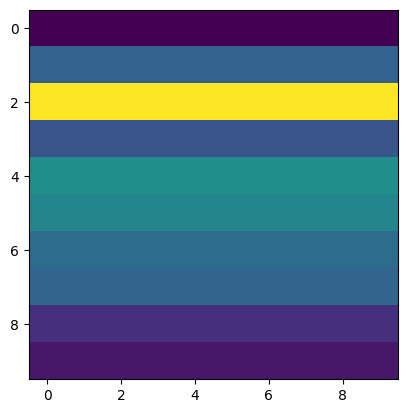

In [19]:
plt.imshow(g2_1.get())

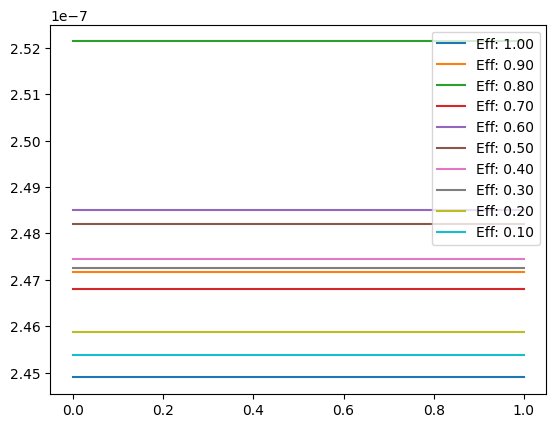

In [20]:
for i in range(len(eficiencias)):
    plt.plot(osc.get(), g2_1[i].get(), label=f"Eff: {eficiencias[i].get():.2f}")
    plt.legend()
    plt.grid()